In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
import time
%matplotlib inline

 np.random.randn(next_node,previous_node+1)
 np.random.normal(0,0.3,(next_node,previous_node+1))

In [12]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        self.weights = [  np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            s = np.dot(weight, output_value)
            output_value = np.append([[1]], activation_function(s), axis=0) # add bias node -> size (n+1,1)
        return output_activation_function(output_value[1:][0][0]) # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            #print "back"
            x.append(np.append([[1]], activation_function(s[-1]), axis=0))
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0 
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs, visualize = True): #stochastic gradient descent
        MSE_list = []
        predicted_result = []
        result_df = None
        for epoch in xrange(epochs): 
            MSE = 0 
            gradient = [np.zeros(w.shape) for w in self.weights]
            #gradient = [ np.random.randn(next_node,previous_node+1) 
                            #for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)

                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
            
            MSE, predicted_result = self.evaluate(testing_data)
            MSE_list.append(MSE)
     
        print "MSE = ", MSE_list[-1]
        if visualize: 
            result_df = visualization(testing_data,predicted_result, MSE_list)
        return MSE_list, predicted_result, result_df
    
    def evaluate(self,testing_data):
        MSE = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_value = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            predicted_result.append(predicted_value)
            MSE += np.square(predicted_value - output_value)
        MSE = float(MSE)/testing_data.shape[0]
        return MSE, predicted_result

            

In [13]:
def activation_function(z):
    return np.tanh(z)

In [14]:
def output_activation_function(z):
    return z # linear regression -> identity function

In [15]:
def convert_to_pixel(oldValue, oldRange, oldMin):
    #oldRange = 1 
    newRange = 255 
    newMin = 0
    #oldMin = 0
    newValue = (((oldValue - oldMin) * newRange) / oldRange) + newMin #oldMin = newMin = 0
    return math.ceil(newValue)

def visualization(df, predicted_result, MSE): 
    data = df.copy()
    data['Predicted'] = predicted_result
    new_value = data['Value'].apply(convert_to_pixel, args=(1,0))
    
    
    min_predicted = data['Predicted'].min()
    max_predicted = data['Predicted'].max()
    
    new_predicted = data['Predicted'].apply(convert_to_pixel, args=(max_predicted-min_predicted,min_predicted))
    data.Value = new_value
    data.Predicted = new_predicted
    plt.plot(MSE)
    plt.title('MSE plot')
    data.plot(kind='scatter',x='x',y='y',c='Value', title="True Plot")
    data.plot(kind='scatter',x='x',y='y',c='Predicted', title="Predicted Plot")
    plt.show()
    return data

#### Create dataframe

In [16]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [17]:
def z_score(df):
    new_df = df.copy()
    new_df.x = (new_df.x - new_df.x.mean())/new_df.x.std(ddof=0)
    new_df.y = (new_df.y - new_df.y.mean())/new_df.y.std(ddof=0)
    return new_df

In [18]:
df = pd.read_csv('donneespb3.txt', sep=' ', header=None)
df.columns = ['x','y','Value']
df = str_to_float(df)
df = z_score(df)

In [19]:
df.describe()

,x,y,Value
count,3.000000e+03,3.000000e+03,3000.000000
mean,-1.588877e-15,-1.724546e-16,0.473798
std,1.000167e+00,1.000167e+00,0.350761
min,-1.742213e+00,-1.709756e+00,0.000010
25%,-8.563515e-01,-8.625151e-01,0.127083
50%,2.924538e-02,6.958319e-03,0.441669
75%,8.507667e-01,8.673395e-01,0.825775
max,1.737918e+00,1.743687e+00,0.999990


MSE =  0.0139115819363


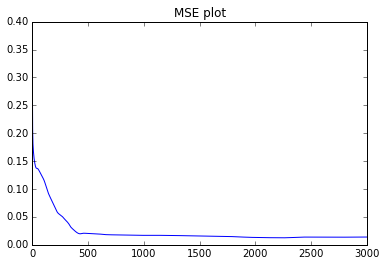

C:\Users\tphan.ENSC\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


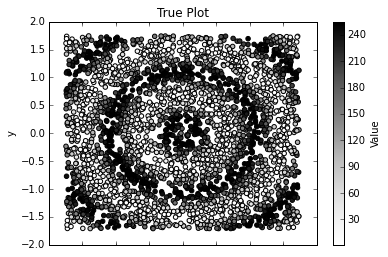

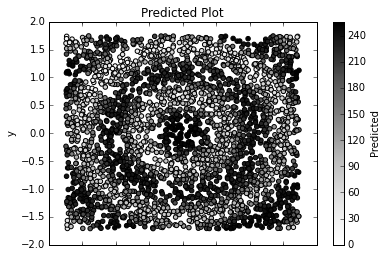

Processing time: 17.95 minutes


In [20]:
neural_net = Network([2,50,1])
t0 = time.clock()
MSE, predicted_result, result = neural_net.SGD(training_data = df, testing_data = df, 
                                             eta = 0.01, epochs = 3000)
print "Processing time: {0:.2f} minutes".format((time.clock() - t0)/60)

#### However, above we have used training data as testing data, and that did not reflect the quality of our model. The neural network is known for its overfitting problem, thus the low MSE received above is not trustworthy. 
#### We will now use cross-validation to assess our model.

In [77]:
from sklearn.cross_validation import KFold

In [78]:
data = pd.read_csv('donneespb3.txt', sep=' ', header=None)
data.columns = ['x','y','Value']
data = str_to_float(data)
data = z_score(data)

In [79]:
def kfold_neural_net(neural_net,algorithm, n_folds, data, epochs):
    kf = KFold( n=data.shape[0], n_folds=n_folds, shuffle=False,random_state=None)
    cumulative_MSE = 0
    counter = 1
    for train_index, test_index in kf:
        neural_net = Network(neural_net)
        train_set = data.iloc[train_index,:]
        test_set = data.iloc[test_index,:]
        print "Iteration {0}: ".format(counter),
        MSE_list, predicted_result, d = algorithm.SGD(training_data = train_set, testing_data = test_set, 
                    eta = 0.01, epochs = epochs, visualize = False)
        cumulative_MSE += MSE_list[-1]
        counter+=1
    print
    print "Average MSE = ", cumulative_MSE/float(n_folds)

In [81]:

kfold_neural_net(neural_net = [2,50,1], n_folds = 10, data = data, epochs = 100)

Iteration 1:  MSE =  0.122348922926
Iteration 2:  MSE =  0.131017805661
Iteration 3:  MSE =  0.125197093595
Iteration 4:  MSE =  0.109476278519
Iteration 5:  MSE =  0.123734955399
Iteration 6:  MSE =  0.114813869345
Iteration 7:  MSE =  0.108268286855
Iteration 8:  MSE =  0.099563237558
Iteration 9:  MSE =  0.106539011303
Iteration 10:  MSE =  0.0973187028448

Average MSE =  0.113827816401
